#Overview
This is an exploration of how the RoPE encoding works with attention.




## High dimensional space

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
import copy
model_dimension=512

def unitvect(d=model_dimension,n=1):
    v=np.random.randn(n,d)
    v=(v/norm(v,axis=1).reshape(-1,1)).squeeze()
    return v

def unit_matrix(d=model_dimension):
    U, S, VT = np.linalg.svd(np.random.rand(d, d))
    return U@VT

In [ ]:
# @title
# m1 = np.random.rand(3, 3)
# print(f"{m1=}")
# U, S, VT = np.linalg.svd(m1)
# print(f"{S=}")
# print(f"{U.shape=}")
# print(f"{VT.shape=}")
# print(f"{S.shape=}")
# print(f"{(U@S).shape=}")
# m2=U@np.diag(S)@VT
# print(f"{np.allclose(m1,m1)=}")
# m3=U@VT
# S1=np.ones_like(S)
# m4=U@np.diag(S1)@VT
# print(f"{np.allclose(m3,m4)=}")
# print(f"{S1=}")

m1=array([[9.92826018e-01, 6.10387762e-01, 1.57106143e-01],
       [2.49125140e-01, 4.34473715e-04, 7.66203767e-01],
       [1.68066689e-01, 2.20838803e-01, 9.21847384e-01]])
S=array([1.43195832, 0.93888014, 0.16403978])
U.shape=(3, 3)
VT.shape=(3, 3)
S.shape=(3,)
(U@S).shape=(3,)
np.allclose(m1,m1)=True
np.allclose(m3,m4)=True
S1=array([1., 1., 1.])


Demonstrate the unitvect is norm==1 and unit_matrix doesnt change norm(v)

In [ ]:
v1,v2=unitvect(n=2)
print(f"{norm(v1)=}")
print(f"{norm(v2)=}")
m1=unit_matrix()
v3=v1@m1
print(f"{norm(v3)=}")

# demonstrate that unit_matrix does not change norm
m1=unit_matrix(d=3)
for i in range(3):
  v=unitvect(d=3)
  v3=v@m1
  if not math.isclose(norm(v3),1.0):
    print(f"{norm(v3)=}")

norm(v1)=1.0
norm(v2)=0.9999999999999999
norm(v3)=1.0


First some high dimensional math examples.

In [ ]:
sim=np.array([unitvect().T@unitvect() for i in range(1000)])
print(f"Similarity between random unit vectors in high dimensional space")
print(f"{np.mean(sim)=}")
print(f"{np.std(sim)=}")
print()
print(f"{1/math.sqrt(model_dimension)=}")
print()
print(f"norm of sum of two random unit vectors in high dimensional space")
print(f"{np.mean([norm(unitvect()+unitvect()) for i in range(10000)])}")

Similarity between random unit vectors in high dimensional space
np.mean(sim)=-0.0012052508886872247
np.std(sim)=0.044075563283204

1/math.sqrt(model_dimension)=0.044194173824159216

norm of sum of two random unit vectors in high dimensional space
1.413861786247914


Super position is the adding of high dimensional vectors.  The sum can be similar to all of the added vectors.


In [ ]:
a=unitvect()
b=unitvect()
c=unitvect()
s=a+b
print(f"{norm(a.T@s)=}")
print(f"{norm(b.T@s)=}")
print(f"{norm(c.T@s)=}")

norm(a.T@s)=1.0721272441650922
norm(b.T@s)=1.0721272441650922
norm(c.T@s)=0.034131223666715865


How does a vector grow as we add more random unit vectors. Why does this flatten out?

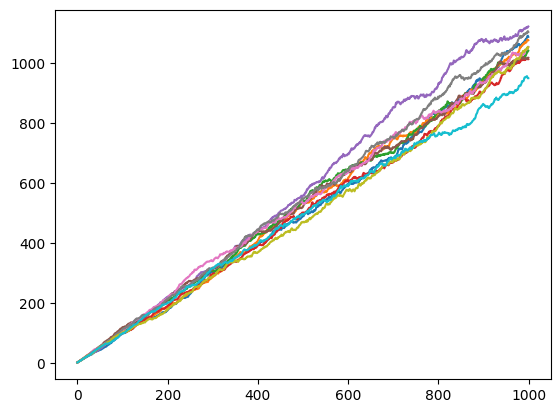

In [ ]:
for example in range(10):
  ref=unitvect()
  s=copy.copy(ref)
  res=[]
  for cnt in range(1000):
    res.append(norm(s))
    s+=unitvect()
  plt.plot(np.array(res)**2)
plt.show()

Superposition without norm.

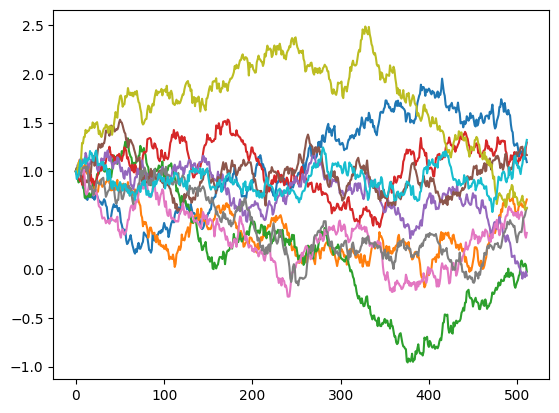

In [ ]:
for example in range(10):
  ref=unitvect()
  s=copy.copy(ref)
  res=[]
  for cnt in range(512):
    v=s.T@ref
    res.append(v.item())
    s+=unitvect()
  plt.plot(np.array(res))
plt.show()

## Original additive position embedding

The original attention is all you need paper used additive embedding. Lets look at the norm of the token embedding with additive position embedding


In [ ]:
def posembed(pos, d=model_dimension):
  r=[]
  for i2 in range(0,d,2):
    t=pos / (10000 ** (i2 / d))
    r.append(np.sin(t) )
    r.append(np.cos(t) )
  return np.array(r)


additive positioning changes magnitude of embedding

In [ ]:
v=unitvect()
print(f"{v.shape=}")
print(f"{norm(v)=}")
m=np.array([posembed(i) for i in range(1000)])
print(f"{m.shape=}")
vm=v+m
print(f"{vm.shape=}")
print()
print(f"{np.mean([norm(x) for x in m])=}")
print(f"{np.std([norm(x) for x in m])=}")
print()
print(f"{np.mean([norm(x) for x in vm])=}")
print(f"{np.std([norm(x) for x in vm])=}")


v.shape=(512,)
norm(v)=1.0
m.shape=(1000, 512)
vm.shape=(1000, 512)

np.mean([norm(x) for x in m])=16.0
np.std([norm(x) for x in m])=5.891509130072236e-16

np.mean([norm(x) for x in vm])=16.017785027587884
np.std([norm(x) for x in vm])=0.03212770027230189


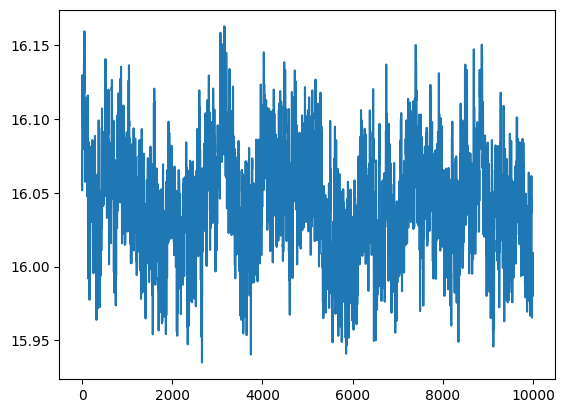

In [ ]:
v=unitvect()
m=[norm(v+posembed(i)) for i in range(10000)]
plt.plot(m)

## RoPE Rotary Positional Embedding

RoPE defines a multiplicative position embedding. This function will apply the position embedding for position pos to the vector x.

 Θ = $θ_i = 10000^{-2(i-1)/d}$, where $i ∈ [1, 2, ..., d/2]$

 $cos(mθ_1)$

 Here we will use a formulation that most closely matches the paper.

In [ ]:
def rope(x, pos, d=None):
  if d is None:
    d=x.shape[0]
  r=[]
  for i in range(1,d//2+1):
    even = x[(i-1)*2]
    odd = x[(i-1)*2+1]
    mtheta=pos*(10000 ** (-2*(i-1) / d))
    pe1=even*np.cos(mtheta) - odd*np.sin(mtheta)
    pe2=even*np.sin(mtheta) + odd*np.cos(mtheta)
    r.append(pe1)
    r.append(pe2)
  return np.array(r)

Lets look at the magnitude of the embedding with position using Rope.


In [ ]:
for i in range(10):
  v=unitvect()
  vpe=rope(v,i)
  print(norm(vpe))


1.0
0.9999999999999999
1.0
0.9999999999999999
1.0
0.9999999999999999
1.0
1.0
1.0
0.9999999999999999


Now lets assume we have k and q vectors, lets look at the attention/dot-product of the key and query where the key and query are identical. i.e. a perfect match. In this case we are going to rotate the q and k vectors (i.e. not the x token encoding)

In [ ]:
k=unitvect()
q=k
print("no positiion embedding",norm(q.T@k))

k0=rope(k,0)
q0=rope(q,0)
print("position 0 embedding:",norm(q0.T@k0))

q1=rope(q,1)
print("position 1 embedding:",norm(q1.T@k0))

q10=rope(q,10)
print("position 10 embedding:",norm(q10.T@k0))

k10=rope(k0,10)
print("position 10 & 10 embedding:",norm(q10.T@k10))


no positiion embedding 1.0
position 0 embedding: 1.0
position 1 embedding: 0.9621361106436057
position 10 embedding: 0.6564551346855383
position 10 & 10 embedding: 1.0


Let's look at that starting position 110 instead of 0.

In [ ]:
k100=rope(k,100)
k110=rope(k,110)
q110=rope(q,110)
print("q110xk100:",norm(q110.T@k100))
k110b=rope(k100,10)   # rotate k100 another 10 positions
print("q110xk110:",norm(q110.T@k110))

q110xk100: 0.6564551346855385
q110xk110: 1.0


Another way to represent the rotation embedding is using a matrix multiply. Lets test that the results are the same.
This time we use what I found to be a slightly cleaner formulation.

In [ ]:
def rot(pos,d=model_dimension):
    r=np.zeros((d,d))
    for i2 in range(0,d,2):
        mtheta=pos*(10000 ** (-i2 / d))
        r[i2,i2]=np.cos(mtheta)
        r[i2,i2+1]=-np.sin(mtheta)
        r[i2+1,i2]=np.sin(mtheta)
        r[i2+1,i2+1]=np.cos(mtheta)
    return r


Test that the results are the same.

In [ ]:
x=unitvect()
print(x.shape)
R=rot(1)
print(R.shape)
for p in [0,1,2,3,4,5,100,1000,10000]:
  print(f"{p=} {np.allclose(rope(x,p),rot(p)@x)=}")


(512,)
(512, 512)
p=0 np.allclose(rope(x,p),rot(p)@x)=True
p=1 np.allclose(rope(x,p),rot(p)@x)=True
p=2 np.allclose(rope(x,p),rot(p)@x)=True
p=3 np.allclose(rope(x,p),rot(p)@x)=True
p=4 np.allclose(rope(x,p),rot(p)@x)=True
p=5 np.allclose(rope(x,p),rot(p)@x)=True
p=100 np.allclose(rope(x,p),rot(p)@x)=True
p=1000 np.allclose(rope(x,p),rot(p)@x)=True
p=10000 np.allclose(rope(x,p),rot(p)@x)=True


Let's also show that Rotation is invertible.

In [ ]:
Rf=rot(100) # rotate forward
Rb=rot(-100) # rotate backward
print(f"{np.allclose(Rf@Rb,np.eye(model_dimension))=}")
xr=Rf@x
xrr=Rb@xr
print(f"{np.allclose(xrr,x)=}")

np.allclose(Rf@Rb,np.eye(model_dimension))=True
np.allclose(xrr,x)=True


## Weight matrixes that rotate

So far we have evaluated rotation of q and k, but usually the position embedding is 'added' to the token embedding $x_i$ before applying the $W_k$ weights.  So let's introduce the $W_k$ and $W_q$ matrixes and run the same tests after adding embedding to $x_i$.  For this example the $W_k$ and $W_q$ weigth matrixes will be identical for a perfect match.


In [ ]:
x=unitvect()
Wk=unit_matrix()
Wq=Wk

print(x.shape)
print(Wk.shape)

(512,)
(512, 512)


First lets create the embeded $x_i$, then use the weight matrixes to create the $q_i$ and $k_i$ vectors


In [ ]:
x0=rope(x,0)
x1=rope(x,1)
x10=rope(x,10)

k0=Wk@x0
k1=Wk@x1
k10=Wk@x10
q0=Wq@x0
q10=Wq@x10

And lets look at the attention/dot-product/similarity values.

First evaluate query at position 10 against the position embedded values




In [ ]:
print("q10.T@k0 : ",norm(q10.T@k0))
print("q10.T@k10 : ",norm(q10.T@k10))

q10.T@k0 :  0.7071391035122461
q10.T@k10 :  1.0


next rotate the query at 10 backwards 10 positions and evaluate against the key at position 0 and 10

In [ ]:
q10b10=rot(-10)@q10
print(f"{np.allclose(q10,rope(q10b10,10))=}")
print(f"{np.allclose(q10b10,q0)=}")
print("q10b10@k0 : ",norm(q10b10.T@k0))
print("q10b10@k10 : ",norm(q10b10.T@k10))

np.allclose(q10,rope(q10b10,10))=True
np.allclose(q10b10,q0)=True
q10b10@k0 :  1.0
q10b10@k10 :  0.7071391035122461


Now we do the same thing but use a $W_q$ that rotates back 10 positions.


In [ ]:
Wqb10=Wq@rot(-10)
q10b10=Wqb10@x10

print(Wqb10.shape)
print("q10b10@x0 : ",norm(q10b10.T@x0))
print("q10b10@x10 : ",norm(q10b10.T@x10))


(512, 512)
q10b10@x0 :  1.0
q10b10@x10 :  0.7071391035122458


Repeat the same referenced to position 100

In [ ]:
x100=rope(x,100)
k100=Wk@x100
x105=rope(x,105)
k100=Wk@x100
x110=rope(x,110)
k110=Wk@x110
q110=Wq@x110
q110b10=Wqb10@x110
print("q110b10xk100:",norm(q110b10.T@k100))
print("q110b10xk110:",norm(q110b10.T@k110))


q110b10xk100: 1.0
q110b10xk110: 0.707139103512246


Testing Julius's query addition statement.

In [ ]:
Wqb5=Wq@rot(-5)
k105=Wk@x105
q110b5=Wqb5@x110
q110b10=Wqb10@x110
q=q110b5+q110b10
q=q/norm(q)

print("Combined query")
print("q110b10xk100:",norm(q.T@k100))
print("q110b10xk105:",norm(q.T@k105))
print("q110b10xk110:",norm(q.T@k110))


Combined query
q110b10xk100: 0.9383957737866383
q110b10xk105: 0.9383957737866384
q110b10xk110: 0.7823523938671005


## Attention over a sequence

Now lets plot the attention over a sequence of random $x_i$

(0.0, 1.0)

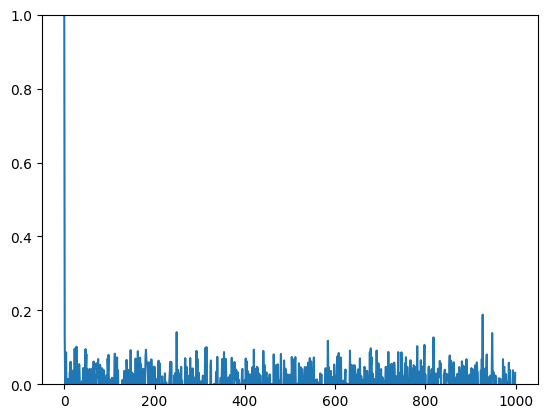

In [ ]:
X=np.array([unitvect() for i in range(1000)]).squeeze()
EP=np.array([rope(x,i) for i,x in enumerate(X)]) #add embedding
q=EP[0]
s=q.T@EP.T
plt.plot(s)
plt.ylim(0,1.0)

Lets search for the same position embedded at location 500.

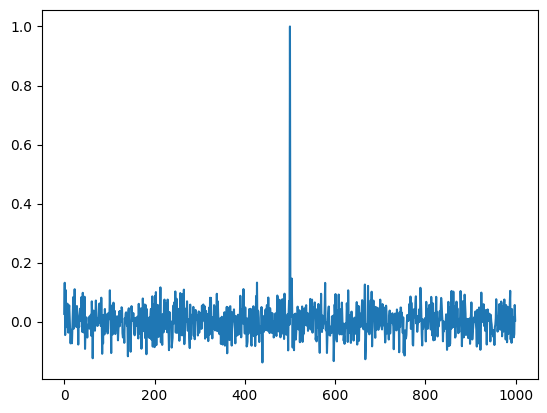

In [ ]:
q=EP[500]
s=q.T@EP.T
plt.plot(s)

## Figure 2 in the RoPE paper

But if we search against 1000 tokens of the same value with different positional embeddings.  I think this should match figure 2 in the RoPE paper, but it is not an exact match.


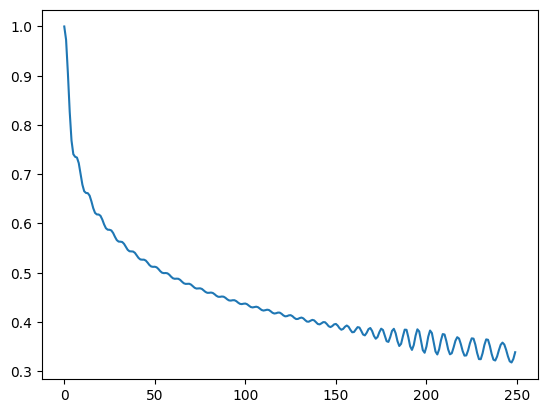

In [ ]:
v=unitvect()
v=np.ones(model_dimension)
v=v/norm(v)
X=np.array([copy.copy(v) for i in range(250)]).squeeze()
EP=np.array([rope(x,i) for i,x in enumerate(X)]) #add embedding

q=EP[0]
s=q.T@EP.T
plt.plot(s)

Let's look at it for different starting vectors. So it appears that the paper was sampling one 'exponential decay', but it is different for every vector.

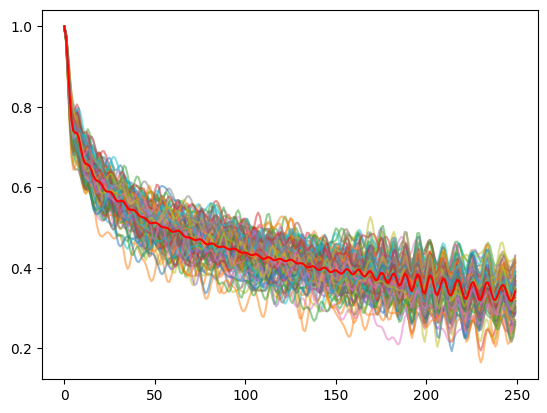

In [ ]:
tot=[]
for i in range(100):
  v=unitvect()
  X=np.array([copy.copy(v) for i in range(250)]).squeeze()
  EP=np.array([rope(x,i) for i,x in enumerate(X)]) #add embedding

  q=EP[0]
  s=q.T@EP.T
  tot.append(s)
  plt.plot(s,alpha=.5)
m=np.mean(np.array(tot),axis=0)
plt.plot(m,color='red')
plt.show()

## Attention with RoPE

Let's look at 10 tokens at different positions in the sequence. This will use a self attention query from position 500.

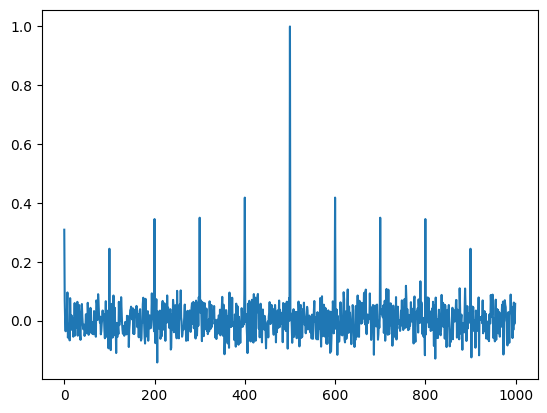

In [ ]:

X=np.array([unitvect() for i in range(1000)]).squeeze()
for i in range(10):
  X[i*100]=X[0]

EP=np.array([rope(x,i) for i,x in enumerate(X)]) #add embedding
q=EP[500]
s=q.T@EP.T
plt.plot(s)

Now we will search for a match 100 positions before position 500

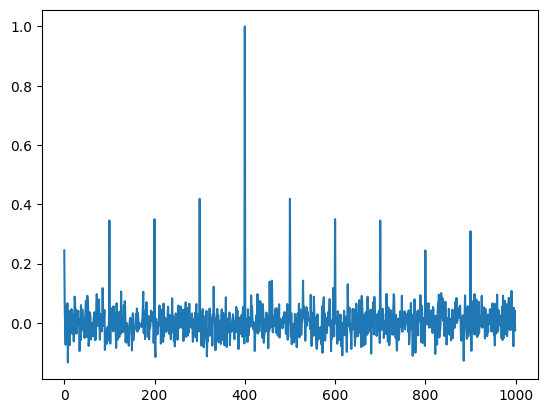

In [ ]:
q=rot(-100)@EP[500]
s=q.T@EP.T
plt.plot(s)

Interesting if it doesnt find a match

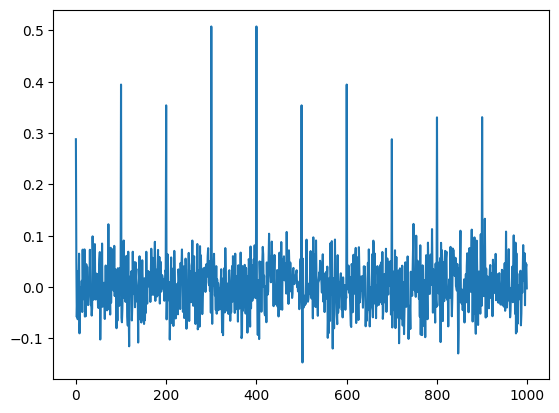

In [ ]:
q=rot(-150)@EP[500]
s=q.T@EP.T
plt.plot(s)


## Making Attention less sensitive

Can we make the attention less sensitive to position?

What we really need is to change $q_i$ to be less selective.  I think the position embedding is in the low order dimensions, so try to just zero out the low order dimensions.


Where does the position embedding really exist?  Looking at the magnitude of the rotation in all dimensions over a long sequence, the position embedding seems to spread over all dimensions

(500, 512)


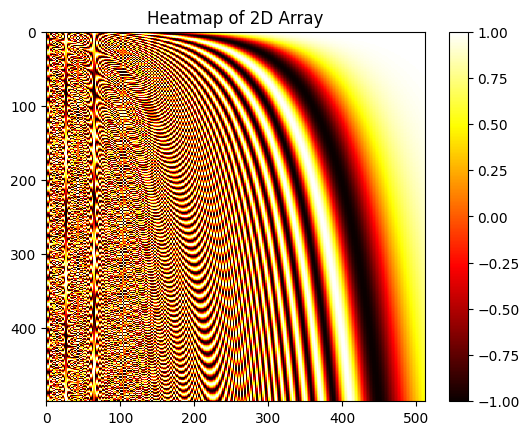

In [ ]:
r=[]
pos=list(range(0,10000,20))
for i in pos:
  v=rot(i)
  r.append(np.diag(v) )
r=np.array(r)
print(r.shape)

plt.imshow(r, cmap='hot', interpolation='nearest')
plt.colorbar()  # Add a colorbar to show values-to-color mapping
plt.title('Heatmap of 2D Array')
plt.show()

But if all we care about is small relative distances, even when the absolute position is very large, then the position embedding has just shifted the entire token embedding space and does not really add superposition noise.


Our hypothesis is that the 'precise location information is placed in the first n dimensions by RoPE, so if we make the query vector ignore the lower dimensions, then precise location should contribute less to the attention score and we should get a smoother attention. As a note: this can also be achieved by making the keys not include the low dimensions. This could be done by the $W_k$ matrix. Or it could be learned during training of the token embedding $x_i$



norm(q)=1.0 norm(q2)=0.7048643896870502
norm(q)=1.0 norm(q3)=1.0


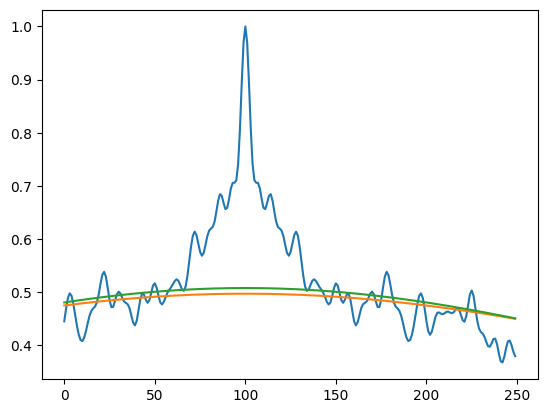

In [ ]:
x0=unitvect()
X=np.array([copy.copy(x0) for i in range(250)]).squeeze()
EP=np.array([rope(x,i) for i,x in enumerate(X)]) #add embedding
q=rot(-100)@EP[200].T
s=q.T@EP.T
plt.plot(s)

# zero out the lower 'spread' dimensions in query
spread=260
q2=copy.copy(q)
q2[:spread]=0
q2=q2
print(f"{norm(q)=} {norm(q2)=}")
s2=q2.T@EP.T
plt.plot(s2)


# zero out the lower 'spread' dimensions in keys
spread=250
q3=copy.copy(q)
EPN=EP.copy()
EPN[:,:spread]=0
print(f"{norm(q)=} {norm(q3)=}")
s3=q3.T@EPN.T
plt.plot(s3)
plt.show()

Lets look at a longer window.

norm(q)=0.9999999999999999 norm(q2)=0.7229560832900717
norm(q)=0.9999999999999999 norm(q2)=0.5826978258823678


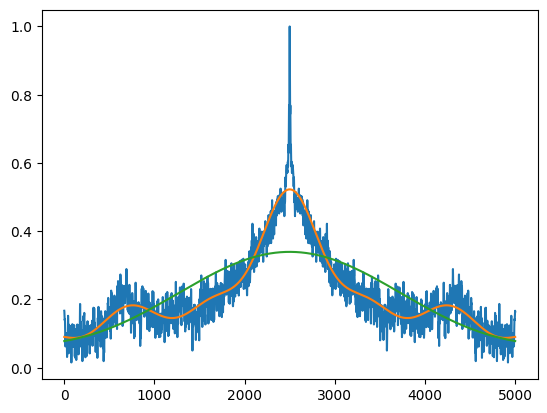

In [ ]:
x0=unitvect()
X=np.array([copy.copy(x0) for i in range(5000)]).squeeze()
EP=np.array([rope(x,i) for i,x in enumerate(X)]) #add embedding
q=rot(-2500)@EP[-1].T
s=q.T@EP.T
plt.plot(s)
sref=s

# zero out the lower 'spread' dimensions in query
spread=260
q2=copy.copy(q)
q2[:spread]=0
q2=q2
print(f"{norm(q)=} {norm(q2)=}")
s2=q2.T@EP.T
plt.plot(s2)

spread=350
q2=copy.copy(q)
q2[:spread]=0
q2=q2
print(f"{norm(q)=} {norm(q2)=}")
s2=q2.T@EP.T
plt.plot(s2)

Testing Julius's query addition

norm(q)=0.9999999999999999 norm(q2)=1.6605410328644046


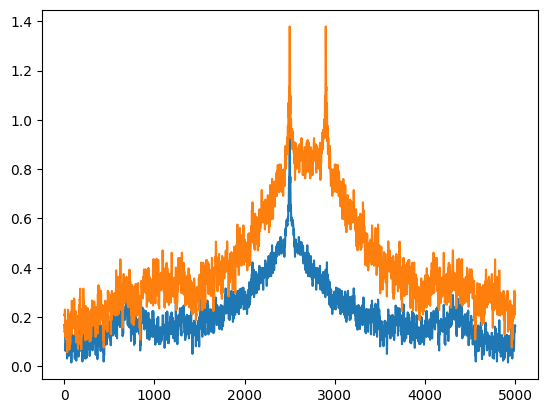

In [ ]:
# run cell above first
plt.plot(sref)

# zero out the lower 'spread' dimensions in query
spread=2
q2=rot(-2500)@EP[-1].T+rot(-2100)@EP[-1].T
print(f"{norm(q)=} {norm(q2)=}")
s2=q2.T@EP.T
plt.plot(s2)


Removing some of the lower frequencies


norm(q)=0.9999999999999999 norm(q2)=1.8129826715134787


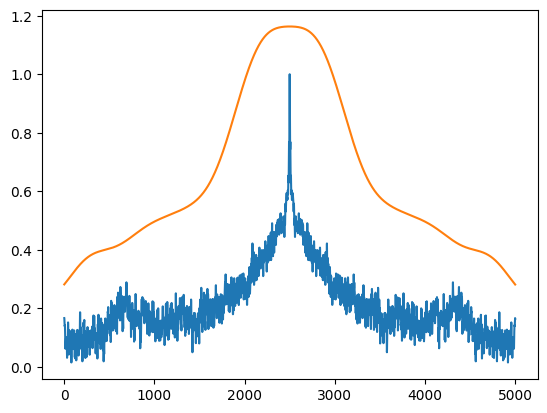

In [ ]:
# run cell above first
plt.plot(sref)

# zero out the lower 'spread' dimensions in query
spread=2
q2=rot(-2500)@EP[-1].T+rot(-2100)@EP[-1].T+rot(-2900)@EP[-1].T
q2[:250]=0

print(f"{norm(q)=} {norm(q2)=}")
s2=q2.T@EP.T
plt.plot(s2)


Adding a few more target positions and relaxing the smoothing make a more square attention

norm(q)=0.9999999999999999 norm(q2)=1.0


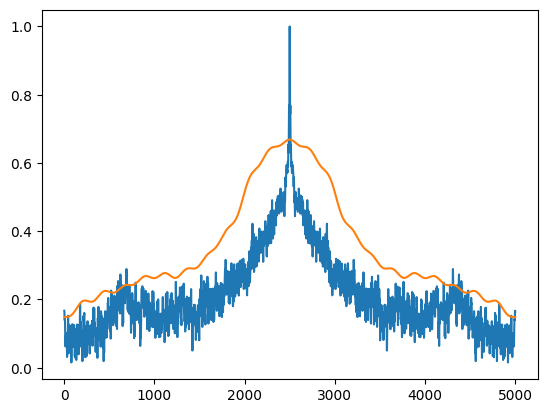

In [ ]:
# run cell above first
plt.plot(sref)

# zero out the lower 'spread' dimensions in query
spread=2
q2=rot(-2500)@EP[-1].T+rot(-2100)@EP[-1].T+rot(-2900)@EP[-1].T+rot(-2300)@EP[-1].T+rot(-2700)@EP[-1].T

q2[:200]=0
q2=q2/norm(q2)

print(f"{norm(q)=} {norm(q2)=}")
s2=q2.T@EP.T
plt.plot(s2)

I'd like to visualize the similarity score by dimension.

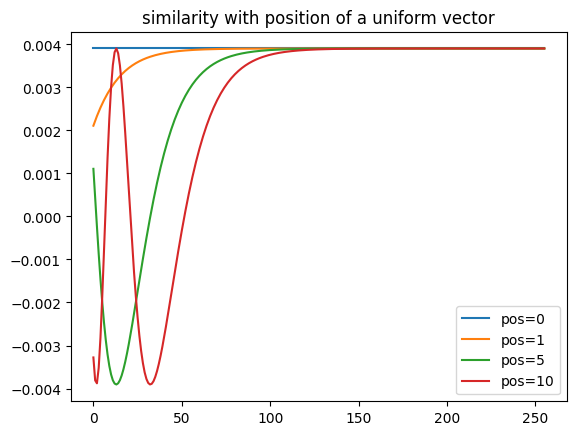

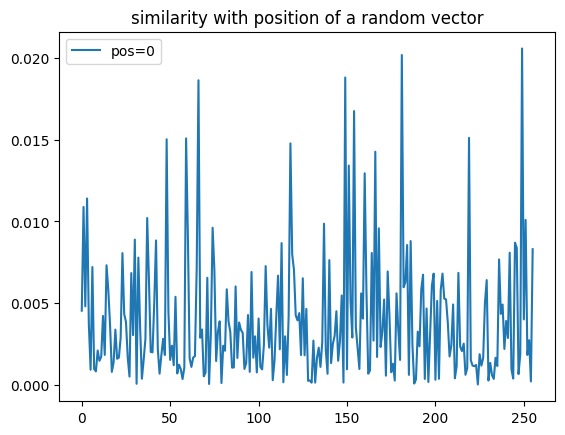

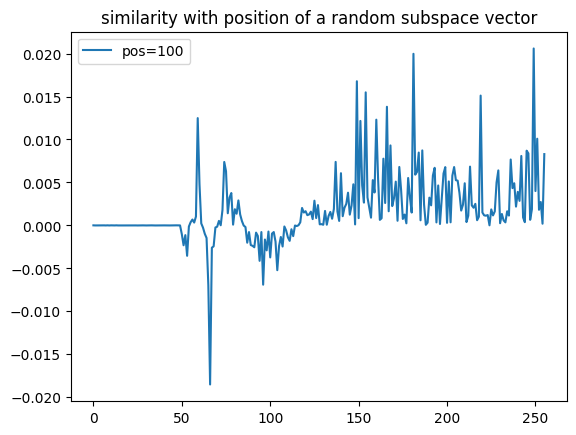

In [ ]:

def rotated_sim(v1,pos):
  v2=copy.copy(v1)
  v2=rot(pos,v2.shape[-1])@v2
  m=v1*v2
  m2=np.sum(m.reshape(-1,2),axis=-1)
  return m2

v1=np.ones((model_dimension))
v1=v1/norm(v1)
for pos in [0,1,5,10]:#,50,100,500,1000,5000]:
  plt.plot(rotated_sim(v1,pos),label=f"pos={pos}")
  plt.legend()
plt.title("similarity with position of a uniform vector")
plt.show()
v1=unitvect()
plt.plot(rotated_sim(v1,0),label=f"pos=0")
plt.legend()
plt.title("similarity with position of a random vector")
plt.show()
v1[:100]=1./v1.shape[-1]
plt.plot(rotated_sim(v1,100),label=f"pos=100")
plt.legend()
plt.title("similarity with position of a random subspace vector")
plt.show()


v100[:4]=array([0.04419417, 0.04419417, 0.04419417, 0.04419417])
v101[:4]=array([ 0.06048788,  0.01573106, -0.06190743,  0.00858602])
m[:4]=array([ 0.00267321,  0.00069522, -0.00273595,  0.00037945])
norm(v100.T@v101)=0.4373055025337377
np.sum(m)=0.4373055025337377
0.044194173824159216
(256, 2)
[[ 0.00267321  0.00069522]
 [-0.00273595  0.00037945]]
np.sum(m2,axis=-1).shape=(256,) 
np.sum(m2)=0.4373055025337377 


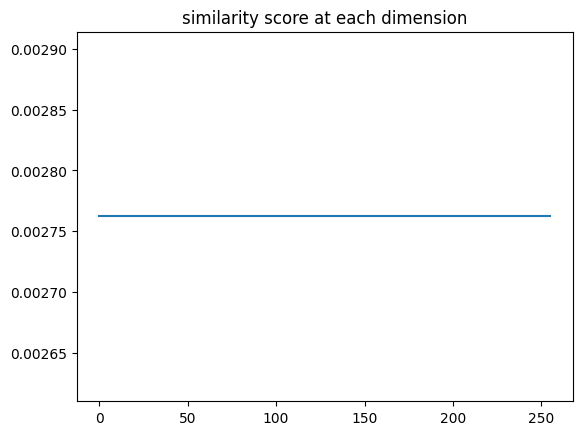

In [ ]:
v=unitvect()
v=np.ones(model_dimension)
v=v/norm(v)

v100=rot(0)@v
v101=rot(100)@v

m=v100.T*v101
print(f"{v100[:4]=}")
print(f"{v101[:4]=}")
print(f"{m[:4]=}")

print(f"{norm(v100.T@v101)=}")
print(f"{np.sum(m)=}")
# print(m[:10])
# print(m[-10:])
print(v[0])
m2=m.reshape(-1,2)
print(m2.shape)
print(m2[:2])
print(f"{np.sum(m2,axis=-1).shape=} ")
print(f"{np.sum(m2)=} ")
plt.plot(norm(m2,axis=-1))
plt.title(f"similarity score at each dimension")
plt.show()


## Additive embedding - a closer look

Lets compare the original additive position embedding.  This is again comparing an exact match between q and k at all positions.  This actually looks smoother.

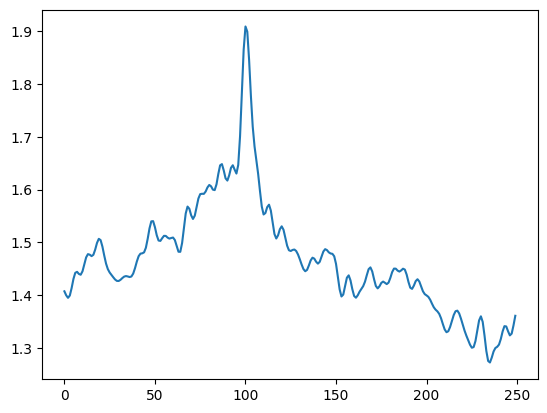

In [ ]:
v=unitvect()
X=np.array([copy.copy(v) for i in range(250)]).squeeze()
EP=np.array([x+0.06*posembed(p) for p,x in enumerate(X)]) #add embedding
q=EP[100]

s=q.T@EP.T

plt.plot(s)
#plt.ylim(0,300)

Lets sample random vectors like we did for RoPE. Additive does not seem to vary as much as RoPE.

(0.0, 300.0)

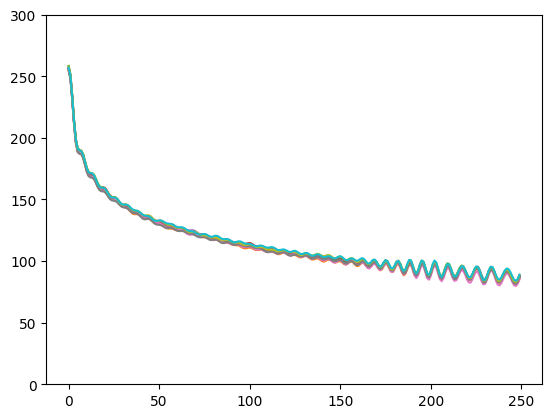

In [ ]:
for i in range(10):
  v=unitvect()
  X=np.array([copy.copy(v) for i in range(250)]).squeeze()
  EP=np.array([x+posembed(p) for p,x in enumerate(X)]) #add embedding
  q=EP[0]
  s=q.T@EP.T
  plt.plot(s)
plt.ylim(0,300)

Try at nonzero location

(0.0, 300.0)

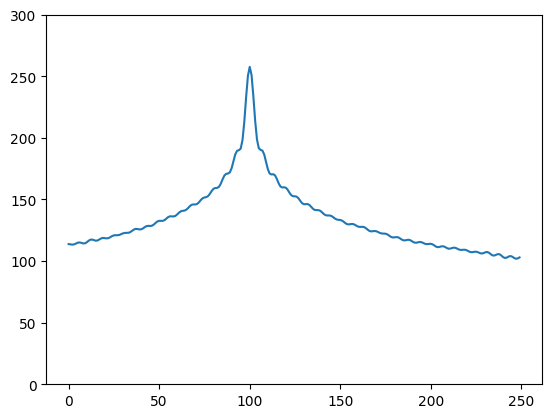

In [ ]:
for i in range(1):
  v=unitvect()
  X=np.array([copy.copy(v) for i in range(250)]).squeeze()
  EP=np.array([x+posembed(p) for p,x in enumerate(X)]) #add embedding
  q=EP[100]
  s=q.T@EP.T
  plt.plot(s)
plt.ylim(0,300)

So the norm of the difference in position is position invariant. I think this is what the authors were hoping the language would learn.

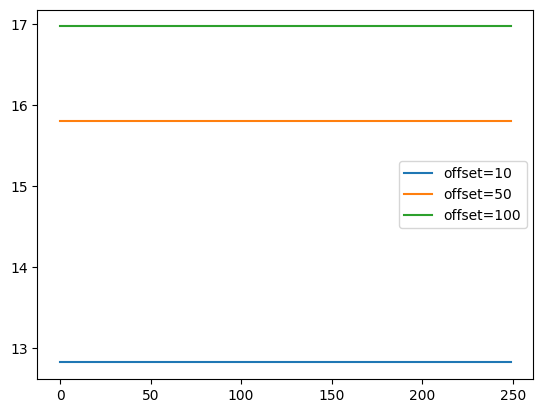

In [ ]:

for offset in [10,50,100]:
  m=[]
  for i in range(250):
    m.append(norm(posembed(i)-posembed(i+offset)))
  plt.plot(m,label=f"offset={offset}")
plt.legend()
plt.show()

But while the norm of the difference is the same, the difference is not the same.

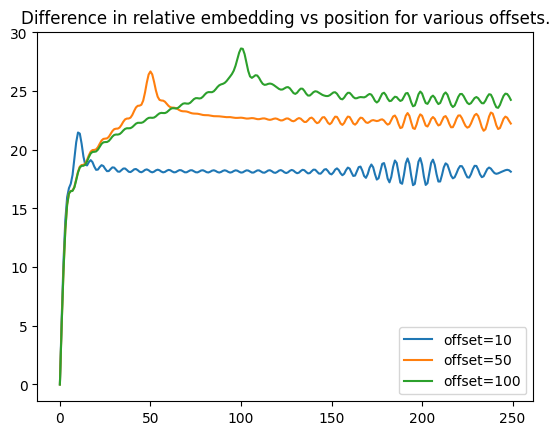

In [ ]:
plt.title("Difference in relative embedding vs position for various offsets.")
for offset in [10,50,100]:
  m=[]
  diff=posembed(0)-posembed(0+offset)
  for i in range(250):
    m.append(norm(diff - (posembed(i)-posembed(i+offset))))
  plt.plot(m,label=f"offset={offset}")
plt.legend()
plt.show()

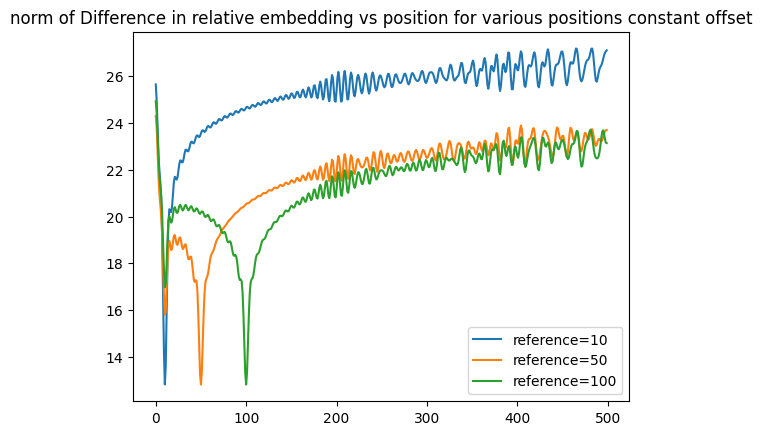

In [ ]:
plt.title("norm of Difference in relative embedding vs position for various positions constant offset")
offset=10
for pos_ref in [10,50,100]:
  m=[]
  diff=posembed(0)-posembed(0+offset)
  for pos in range(500):
    m.append(norm(diff - (posembed(pos_ref)-posembed(pos))))
  plt.plot(m,label=f"reference={pos_ref}")
plt.legend()
plt.show()

Is additive embedding relative?


In [ ]:
k=unitvect()
q=copy.copy(k)
q0=q+posembed(0)
k0=x+posembed(0)
q10=q+posembed(10)
k10=x+posembed(10)
print(f"{norm(q0.T@k0)=}")
print(f"{norm(q10.T@k10)=}")
q10b=q10-posembed(10)+posembed(0)
print(f"{norm(q10b.T@k0)=}")
print(f"{norm(q10b.T@k10)=}")


norm(q0.T@k0)=256.24793244689397
norm(q10.T@k10)=255.646920153978
norm(q10b.T@k0)=256.24793244689397
norm(q10b.T@k10)=173.52072437377493


## Softmax

Now lets look at the effect of the softmax in attention.

Before we look at what softmax does to the attention similarity plot, Let's look at softmax.

$\displaystyle \sigma (\mathbf {z} )_{i}={\frac {e^{z_{i}}}{\sum _{j=1}^{K}e^{z_{j}}}}$

Numpy doesn't implement softmax, so we code a function, but the results were unexpected, so I also compare it to torch softmax.

In [ ]:
def softmax(x, temperature=1):
  e_x = np.exp((x/ temperature  - np.max(x/ temperature)))
  return e_x / e_x.sum(axis=-1)

import torch.nn.functional as F
import torch
def softmax2(x):
    return F.softmax(torch.tensor(x), dim=0).tolist()  # Assuming input is a NumPy array

In [ ]:
v=np.array([0.2,0.6])
print(v)
print(v/np.sum(v))
print(softmax(v))
print(softmax2(v))

[0.2 0.6]
[0.25 0.75]
[0.40131234 0.59868766]
[0.401312339887548, 0.598687660112452]


The hot logits were actually squashed instead of lifted.  Turns out it only lifts if the logits are above 1.0

In [ ]:
v=np.array([2.,6.])
print(v)
print(v/np.sum(v))
print(softmax(v))
print(softmax2(v))

[2. 6.]
[0.25 0.75]
[0.01798621 0.98201379]
[0.017986209962091555, 0.9820137900379085]


So looking at our attention without scaling the attention is squashed.

(1000, 512)
(1000, 512)
(512,)


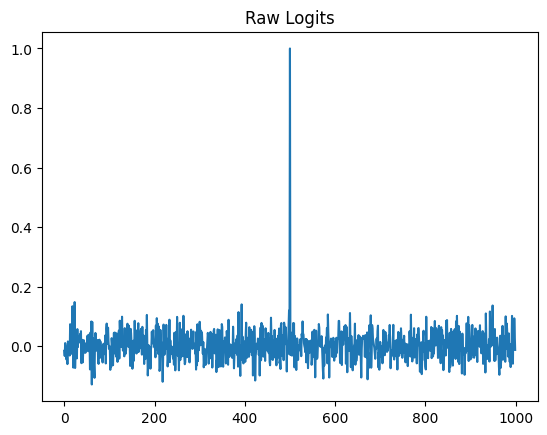

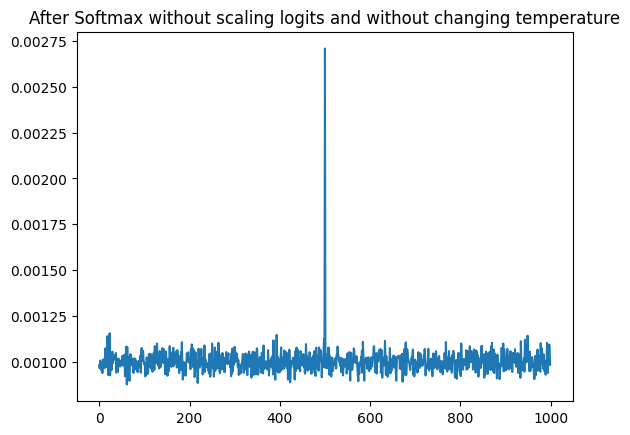

In [ ]:
X=np.array([unitvect() for i in range(1000)]).squeeze()
EP=np.array([rope(x,i) for i,x in enumerate(X)]) #add embedding
q=EP[500]
print(X.shape)
print(EP.shape)
print(q.shape)
s=q.T@EP.T
plt.plot(s)
plt.title("Raw Logits")
plt.show()

sm=softmax(s) #/np.sqrt(model_dimension))
plt.plot(sm)
plt.title("After Softmax without scaling logits and without changing temperature")
plt.show()


So if we scale the logits well, then we amplify the 'winner' logit.  That was unexpected to me.

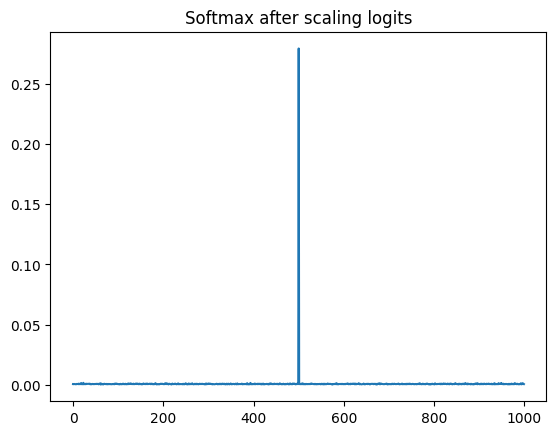

In [ ]:
sm=softmax(s*6)#/np.sqrt(model_dimension))
plt.plot(sm)
plt.title("Softmax after scaling logits")
plt.show()

This can also be done with temperature.

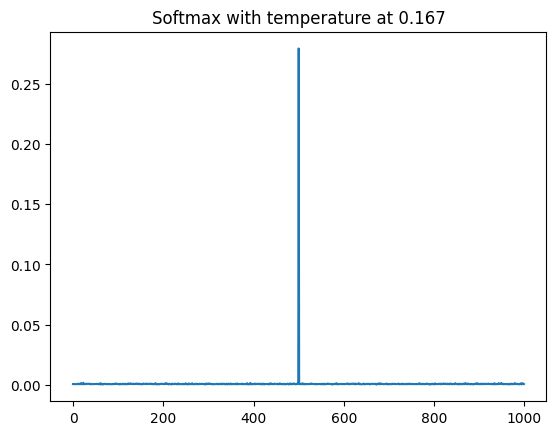

In [ ]:
sm=softmax(s,temperature=1/6.0)#/np.sqrt(model_dimension))
plt.plot(sm)
plt.title(f"Softmax with temperature at {1/6.0:.3f}")
plt.show()

Now try attention with RoPE and softmax.

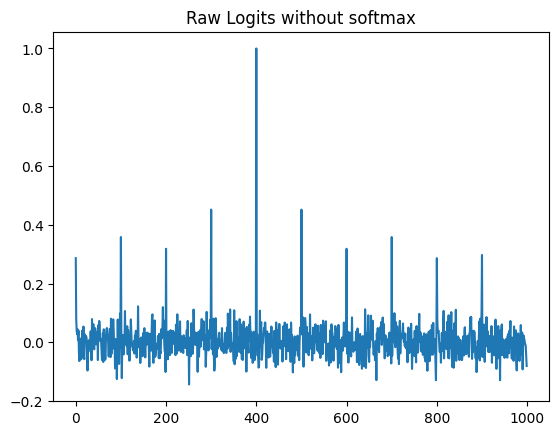

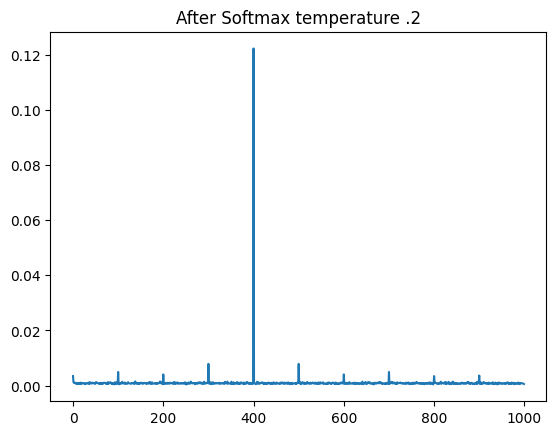

In [ ]:
X=np.array([unitvect() for i in range(1000)]).squeeze()
for i in range(10):
  X[i*100]=X[0]

EP=np.array([rope(x,i) for i,x in enumerate(X)]) #add embedding
q=rot(-500)@EP[900]
s=q.T@EP.T
plt.plot(s)
plt.title("Raw Logits without softmax")
plt.show()

sm=softmax(s,temperature=.2)
plt.plot(sm)
plt.title("After Softmax temperature .2")
plt.show()


When position is not exact match.

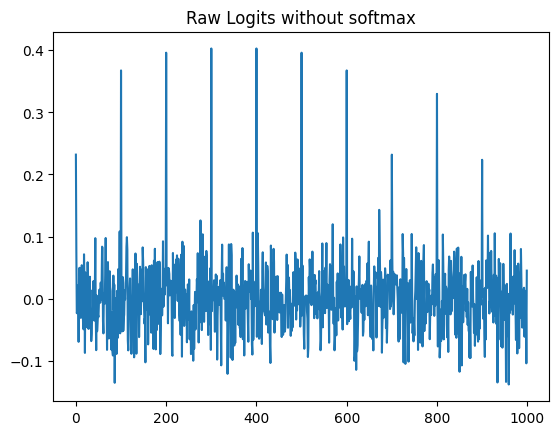

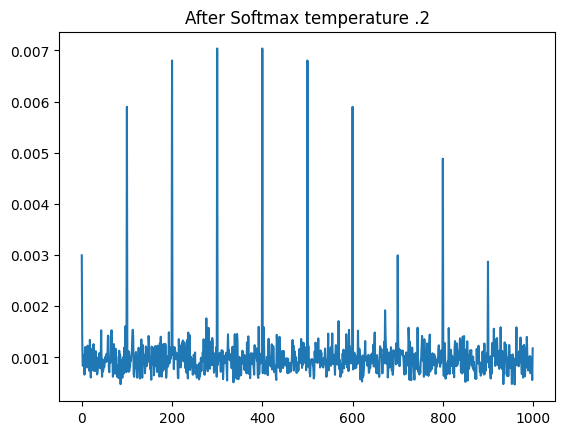

In [ ]:
X=np.array([unitvect() for i in range(1000)]).squeeze()
for i in range(10):
  X[i*100]=X[0]

EP=np.array([rope(x,i) for i,x in enumerate(X)]) #add embedding
q=rot(-550)@EP[900]
s=q.T@EP.T
plt.plot(s)
plt.title("Raw Logits without softmax")
plt.show()

sm=softmax(s,temperature=.2)
plt.plot(sm)
plt.title("After Softmax temperature .2")
plt.show()

## Subspaces

Lets play with subspaces to gain some intuition.  First we need some utilities.

In [ ]:
def orthogonal_basis(n,exclude=[]):
  if isinstance(exclude,np.ndarray):
    exclude=list(exclude)
  basis=[]
  for i in range(n):
    axis=unitvect()
    for b in basis+exclude:
      axis=axis-(b@axis)*b
    basis.append(axis/norm(axis))
  return np.array(basis)

def project_to_subspace(v,basis):
  v2=np.zeros_like(v)
  for b in basis:
    v2+=(b@v)*b
  return v2/norm(v2)

def subunitvect(basis,d=model_dimension):
  v=unitvect(d)
  return project_to_subspace(v,basis)

def validate_orthogonal_basis(basis):
  for i1,b1 in enumerate(basis):
    for i2,b2 in enumerate(basis):
      s=b1.T@b2
      if i1==i2:
        assert math.isclose(s,1.0)
      else:
        assert math.isclose(s,0.0,abs_tol=1e-9)

def validate_orthogonal_subspace(basis1,basis2):
  for i1,b1 in enumerate(basis1):
    for i2,b2 in enumerate(basis2):
      s=b1.T@b2
      assert math.isclose(s,0.0,abs_tol=1e-9)

def validate_within_subspace(basis,v):
  return np.allclose(project_to_subspace(v,basis),v)

def validate_orthogonal(basis):
  for i1,b1 in enumerate(basis):
    for i2,b2 in enumerate(basis):
      s=b1.T@b2
      if i1==i2:
        assert math.isclose(s,1.0)


basis=orthogonal_basis(10)

validate_orthogonal_basis(basis)

v=unitvect()

v2=project_to_subspace(v,basis)

validate_within_subspace(basis,v2)

basis2=orthogonal_basis(10,exclude=basis)

validate_orthogonal(basis2)
v3=subunitvect(basis2)

validate_within_subspace(basis2,v3)
validate_orthogonal_subspace(basis,basis2)



Now test superposition with subspaces.

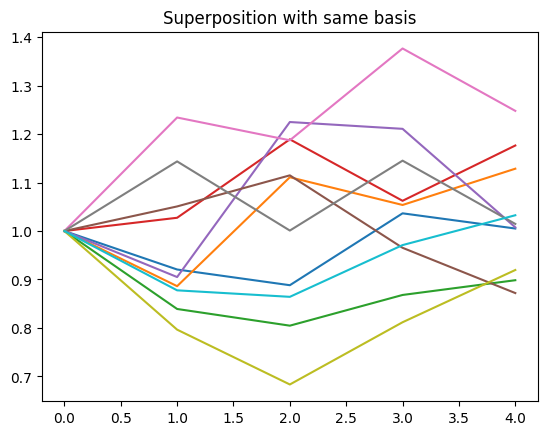

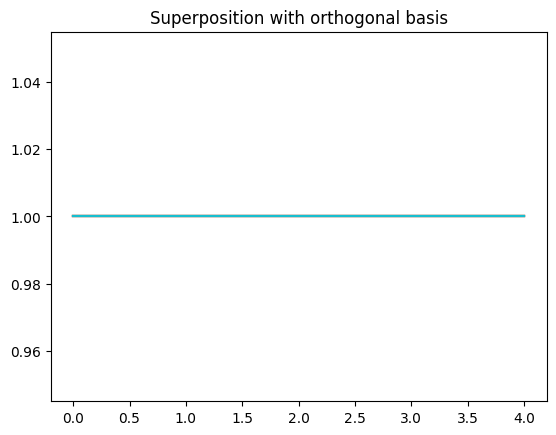

In [ ]:
basis1=orthogonal_basis(100)
basis2=orthogonal_basis(100,basis1)
for lbl,otherbasis in [("same",basis1),('orthogonal',basis2)]:
  for example in range(10):
    ref=subunitvect(basis1)
    s=copy.copy(ref)
    res=[]
    for cnt in range(5):
      v=s.T@ref
      res.append(v.item())
      s+=subunitvect(otherbasis)
    plt.plot(np.array(res))
  plt.title(f"Superposition with {lbl} basis")
  plt.show()

Now lets create a subspace that does not include lower dimensions. Lets recreate figure 2 with this new subspace

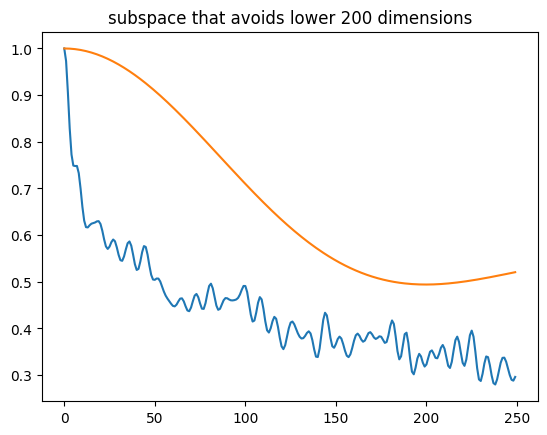

In [ ]:
# reference line
v=unitvect()
X=np.array([copy.copy(v) for i in range(250)]).squeeze()
EP=np.array([rope(x,i) for i,x in enumerate(X)]) #add embedding

q=EP[0]
sref=q.T@EP.T
plt.plot(sref)


# now with subspace
def subEP(n,l=250):
  npos_basis = np.eye(model_dimension)[n:]
  validate_orthogonal_basis(npos_basis)
  v=subunitvect(npos_basis)
  X=np.array([copy.copy(v) for i in range(l)]).squeeze()
  EP=np.array([rope(x,i) for i,x in enumerate(X)]) #add embedding
  return EP

EP=subEP(200)
q=EP[0]
s=q.T@EP.T
plt.plot(s)
plt.title("subspace that avoids lower 200 dimensions")
plt.show()



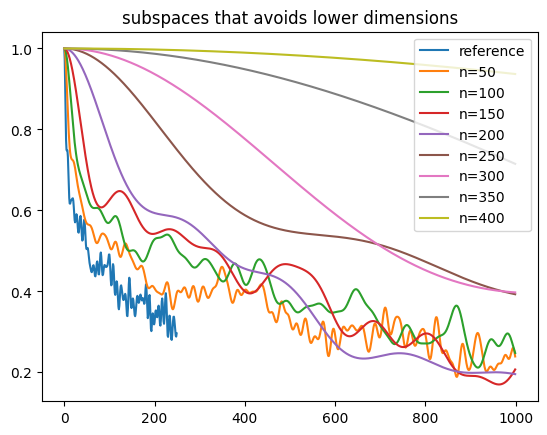

In [ ]:
plt.plot(sref,label='reference')


for n in [50,100,150,200,250,300,350,400]:
  EP=subEP(n,l=1000)
  q=EP[0]
  s=q.T@EP.T
  plt.plot(s,label=f"n={n}")
plt.legend()
plt.title("subspaces that avoids lower dimensions")
plt.show()

What does it look like with random subspaces that are not excluded from the lower dimensions.

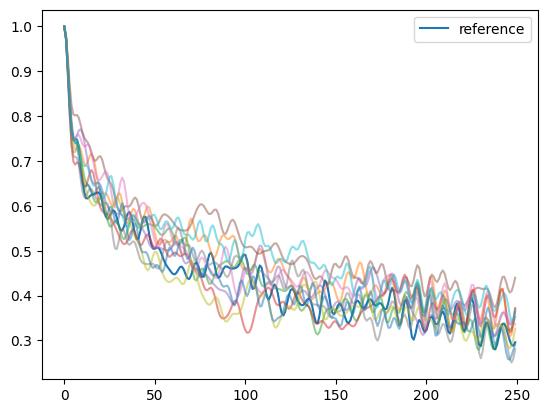

In [ ]:
# now with subspace
plt.plot(sref,label='reference')
for i in range(10):
  basis1=orthogonal_basis(100)
  v=subunitvect(basis1)
  X=np.array([copy.copy(v) for i in range(250)]).squeeze()
  EP=np.array([rope(x,i) for i,x in enumerate(X)]) #add embedding
  q=EP[0]
  s=q.T@EP.T
  plt.plot(s,alpha=.5)
plt.legend()
plt.show()

## Work with Ted

$x_i$ token embedding

$k_i$ key with embedding at position i

$q_i$ query with embedding at position i

$rot_i$ = rotation matrix at position i

$q = W_q * x_i$

$q_i = W_q * x_i * rot_i$

$r_i = x_i * rot_i$

$q_i = W_q * r_i$

$q_m * k_n$ constant for large range of n


In [ ]:
k=unitvect()
q=copy.copy(k)
k=rot(0)@k
q=rot(0)@q
m=q.T*k
print(m[:10])
print(f"{norm(q.T@k)=}")

[0.00422139 0.00036487 0.00066611 0.00137384 0.00034365 0.00258241
 0.00122975 0.00153236 0.00059089 0.00333043]
norm(q.T@k)=1.0


In [ ]:
v=unitvect()
X=np.array([copy.copy(v) for i in range(250)]).squeeze()
EP=np.array([rope(x,i) for i,x in enumerate(X)]) #add embedding

# q = ??
# x=unitvect()
# t = x @ rot(i)   # rotated x
# u = (x @ t) / norm(t)  # x projected onto rotated x
# v = x - u   # orthogonal component of x to rotated x
# we want W_k such that W_k * x = v

In [ ]:
k=unitvect()
k=rot(10000)@k
q=rot(-10)@k
print(q.T@k)
d=q.T*k
print(np.sum(d[256:]))

0.6811079680049219
0.5038144805949551


In [ ]:
q=unitvect()
k=rot(10)@q
print(q.T@k)
d=q.T*k
print(np.sum(d[256:]))

0.6801355449336854
0.5133191496637723


In [ ]:
# R=rot(-500)

# e=np.zeros(128)
# R[:e.shape[0],:e.shape[0]]=e
# q=R@EP[900]
# s=q.T@EP.T
# plt.plot(s)